# Synthesis of 2.5D Models Based on Monocular Images
### Boyuan Cheng (ID: s5526309)

In [1]:
import numpy as np
import pandas as pd
import os
import PIL.Image
import torch
import cv2
import random
import dnnlib
import legacy
import time
import torchvision.transforms as T
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from midas.model_loader import load_model
from sklearn.cluster import KMeans
from networks.mat import Generator

## 1. Introduction
With the development of Computer Graphics technology as well as deep learning technology, it has become possible to convert 2D images into 3D models using computer algorithms. In the past few years, many implementations of 3D reconstruction techniques have been proposed, some of which have been widely used in areas such as film and television entertainment, intelligent homes, heritage reconstruction, and autonomous driving and etc. A common method to reconstruct a 3D model is to place multiple depth cameras around an object and capture images simultaneously, and then reconstruct the 3D shape of the object based on the captured images. However, since most systems based on this approach require multiple cameras and synchronization devices, it is difficult for most users to use these systems flexibly. In addition, modeling a 3D scene is generally very complex and time-consuming. Especially in distant scenes that do not require much detail, it is not worth spending much time modeling the scene. 

The data acquisition process required for 2.5D reconstruction is simpler and more economical than that for 3D reconstruction. It typically uses 2D images as input without the complex equipment architecture, which makes it more attractive for individual users, small teams or projects with limited resources. In addition, 2.5D reconstruction is normally faster to process, which makes it practical in applications that require quick results, such as real time surveillance, virtual reality and augmented reality. Hence, in this project, I propose and implement a 2.5D reconstruction method based on monocular camera with user-defined complexity, aiming to make it easier for users to get hands-on and reconstruct the scene model quickly.

## 2. 2.5D Reconstruction System
This section describes the steps and methods of converting the original 2D picture into a 2.5D model, and the overview diagram is shown in Figure below.
![pipline](figure/1.jpg)

### 2.1 Monocular depth estimation

In [2]:
def process(device, model, model_type, image, input_size, target_size, optimize):
    
    sample = torch.from_numpy(image).to(device).unsqueeze(0)
    if optimize and device == torch.device("cuda"):
        sample = sample.to(memory_format=torch.channels_last)
        sample = sample.half()
    height, width = sample.shape[2:]
    prediction = model.forward(sample)
    prediction = (torch.nn.functional.interpolate(prediction.unsqueeze(1),
                                                  size=target_size[::-1],
                                                  mode="bicubic",
                                                  align_corners=False).squeeze().cpu().numpy())
    return prediction


def run(input_img, model_path, model_type="dpt_beit_large_512", optimize=False, side=False, height=None,
        square=False, grayscale=False):
    
    print("Initialize")

    # select device
    device = torch.device("cpu")
    print("Device: %s" % device)

    model, transform, net_w, net_h = load_model(device, model_path, model_type, optimize)

    # get input
    print("Start processing")

    # input in [0, 1]
    image = transform({"image": input_img / 255.0})["image"]

    # compute
    with torch.no_grad():
        prediction = process(device, model, model_type, image, (net_w, net_h), input_img.shape[1::-1],optimize)
        
    depth_min = prediction.min()
    depth_max = prediction.max()
    max_val = (2**(8*1))-1

    if depth_max - depth_min > np.finfo("float").eps:
        out = max_val * (prediction - depth_min) / (depth_max - depth_min)
    else:
        out = np.zeros(prediction.shape, dtype=prediction.dtype)

    out = cv2.applyColorMap(np.uint8(out), cv2.COLORMAP_INFERNO)
    out = cv2.cvtColor(out.astype("uint8"), cv2.COLOR_BGR2RGB)

    print("Finished")
    return out

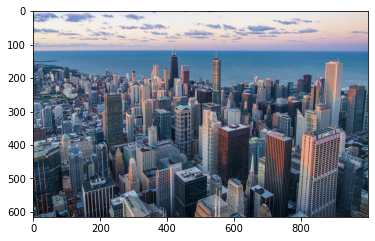

In [4]:
input_img = np.array(PIL.Image.open("input/buildings-1.jpeg"))
plt.imshow(input_img)

In [5]:
output_img = run(input_img = input_img, model_path = "weights/dpt_beit_large_512.pt", model_type='dpt_beit_large_512')

Initialize
Device: cpu
Model loaded, number of parameters = 345M
Start processing
Finished


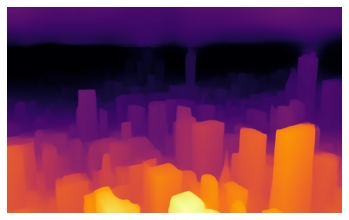

In [6]:
plt.axis("off")
plt.imshow(output_img)

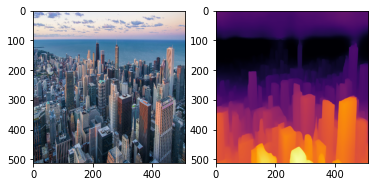

In [7]:
original_shape = input_img.shape
resize_input_img = cv2.resize(input_img,dsize=(512,512), interpolation=cv2.INTER_CUBIC)
resize_output_img = cv2.resize(output_img,dsize=(512,512), interpolation=cv2.INTER_CUBIC)

plt.subplot(1,2,1)
plt.imshow(resize_input_img)
plt.subplot(1,2,2)
plt.imshow(resize_output_img)

### 2.2 Depth Image Segmentation

In [8]:
Pixel_RGB_List = resize_output_img.reshape(resize_output_img.shape[0]*resize_output_img.shape[1],3)
Pixel_RGB_List = np.float32(Pixel_RGB_List)

print("Image segmentation in progress...")
nclass=3 #The number of layers
kmeans_clf = KMeans(n_clusters=nclass)
kmeans_clf.fit(Pixel_RGB_List)
ClfResult = kmeans_clf.labels_

label_df = pd.DataFrame(ClfResult.tolist(),columns=["Label"])
feature_df = pd.DataFrame(Pixel_RGB_List.tolist(),columns=["R","G","B"])
Pixel_df = pd.concat([feature_df,label_df],axis=1)
print("Image segmentation is done.\n")

sorted_average=[]
class_label = []
class_average = kmeans_clf.cluster_centers_
for i in range(len(class_average)):
    sorted_average.append(class_average[i][0])
    class_label.append(i)
average_df = pd.concat([pd.DataFrame(sorted_average,columns=["Average"]),
                        pd.DataFrame(class_label,columns=["Old Labels"])],axis=1)
sorted_average_df = average_df.sort_values(by='Average', ascending=True).reset_index().drop("index",axis=1)
sorted_average_df = pd.concat([sorted_average_df,
                        pd.DataFrame(class_label,columns=["New Labels"])],axis=1)

new_label_list = []
count=1
for old_label in Pixel_df["Label"]:
    if(count==len(Pixel_df)):
        print(f"Hierarchical sorting in progress: 100%",end="\r",flush=True)
    if(count%10000==0):
        print(f"Hierarchical sorting in progress: {round(count/len(Pixel_df)*100)}%",end="\r",flush=True)
        
    for index in range(len(sorted_average_df["Old Labels"])):
        if(old_label==sorted_average_df["Old Labels"][index]):
            new_label_list.append(sorted_average_df["New Labels"][index])
    count+=1
Sorted_Pixel_df = pd.concat([Pixel_df,
                             pd.DataFrame(new_label_list,columns=["New Labels"])],axis=1)
print("\nHierarchical sorting is done.")

Image segmentation in progress...
Image segmentation is done.

Hierarchical sorting in progress: 100%
Hierarchical sorting is done.


### 2.3 Texture Mapping

In [9]:
save_seg_img_list=[]
save_mask_img_list=[]
for m in range(nclass):
    #print(f"The {m+1} time:")
    Seg_img_list=[]
    mask_img_list=[]
    for i in range(len(Pixel_df)):
        if(i%1000==0):
            print(f"Mapping texture to layer {m+1}: {round(i/len(Pixel_df)*100)}%",end="\r",flush=True)
        if((i+1)==len(Pixel_df)):
            print(f"Mapping texture to layer {m+1}: 100%",end="\r",flush=True)
            
        #class No.0 is the layer at the end, the largest class number is the layer at the head.
        
        if(Sorted_Pixel_df["New Labels"][i]==m):
            Seg_img_list.append(resize_input_img.reshape(resize_input_img.shape[0]*resize_input_img.shape[1],3)[i])
            mask_img_list.append(255)
        if(Sorted_Pixel_df["New Labels"][i]>m):
            Seg_img_list.append([255,255,255])
            mask_img_list.append(0)
        if(Sorted_Pixel_df["New Labels"][i]<m):
            Seg_img_list.append([0,0,0])
            mask_img_list.append(255)

    Seg_img_array = np.array(Seg_img_list).reshape(resize_output_img.shape[0],resize_output_img.shape[1],3)
    save_seg_img_list.append(Seg_img_array)
    
    Seg_mask_array = np.array(mask_img_list).reshape(resize_output_img.shape[0],resize_output_img.shape[1])
    save_mask_img_list.append(Seg_mask_array)
    
    print("\nDone")

Mapping texture to layer 1: 100%
Done
Mapping texture to layer 2: 100%
Done
Mapping texture to layer 3: 100%
Done


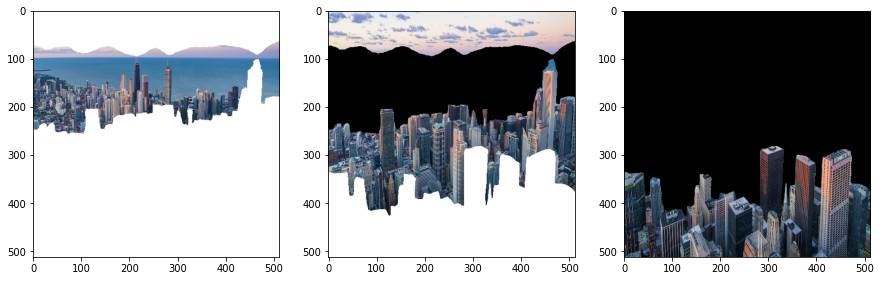

In [10]:
plt.figure(figsize=[15,18])
for i in range(nclass):
    plt.subplot(1,nclass,i+1)
    plt.imshow(save_seg_img_list[i])

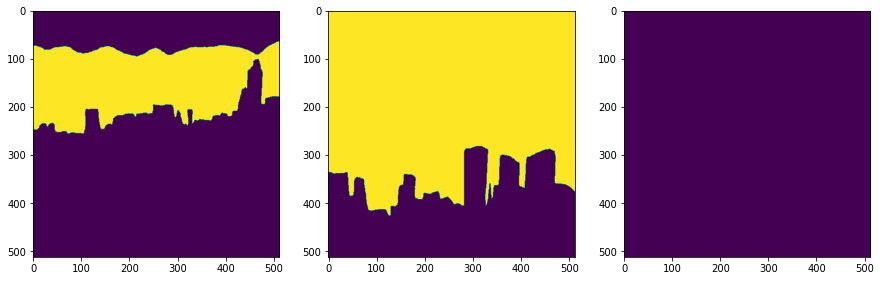

In [11]:
plt.figure(figsize=[15,18])
for i in range(nclass):
   # im = PIL.Image.fromarray(np.uint8(cm.gist_earth(save_mask_img_list[i])*255))
    plt.subplot(1,nclass,i+1)
    plt.imshow(save_mask_img_list[i])

### 2.4 Image Completion

In [12]:
def copy_params_and_buffers(src_module, dst_module, require_all=False):
    assert isinstance(src_module, torch.nn.Module)
    assert isinstance(dst_module, torch.nn.Module)
    src_tensors = {name: tensor for name, tensor in named_params_and_buffers(src_module)}
    for name, tensor in named_params_and_buffers(dst_module):
        assert (name in src_tensors) or (not require_all)
        if name in src_tensors:
            tensor.copy_(src_tensors[name].detach()).requires_grad_(tensor.requires_grad)


def params_and_buffers(module):
    assert isinstance(module, torch.nn.Module)
    return list(module.parameters()) + list(module.buffers())


def named_params_and_buffers(module):
    assert isinstance(module, torch.nn.Module)
    return list(module.named_parameters()) + list(module.named_buffers())


In [13]:
def generate_images(
    network_pkl="weights/Places_512_FullData.pkl",
    image_list=None,
    mask_list=None,
    resolution=512,
    truncation_psi=1,
    noise_mode='const',
    outdir="test_output",
):
    fixing_result_list = []
    seed = 240  # pick up a random number
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    if mask_list is not None:
        assert len(image_list) == len(mask_list), 'illegal mapping'

    print(f'Loading networks from: {network_pkl}')
    device = torch.device('cpu')
    with dnnlib.util.open_url(network_pkl) as f:
        G_saved = legacy.load_network_pkl(f)['G_ema'].to(device).eval().requires_grad_(False) # type: ignore
    net_res = 512 if resolution > 512 else resolution
    G = Generator(z_dim=512, c_dim=0, w_dim=512, img_resolution=net_res, img_channels=3).to(device).eval().requires_grad_(False)
    copy_params_and_buffers(G_saved, G, require_all=True)

    os.makedirs(outdir, exist_ok=True)

    # no Labels.
    label = torch.zeros([1, G.c_dim], device=device)

    if resolution != 512:
        noise_mode = 'random'
    with torch.no_grad():
        for i in range(len(image_list)):
            print(f"Fixing the missing area of image {i+1}",end="\n",flush=True)
            image = (torch.from_numpy(image_list[i]).float().to(device) / 127.5 - 1).unsqueeze(0)

            if mask_list is not None:
                mask = mask_list[i].astype(np.float32) / 255.0
                mask = torch.from_numpy(mask).float().to(device).unsqueeze(0).unsqueeze(0)

            z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
            output = G(image, mask, z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
            output = (output.permute(0, 2, 3, 1) * 127.5 + 127.5).round().clamp(0, 255).to(torch.uint8)
            output = output[0].cpu().numpy()
            #output = cv2.resize(output,dsize=(image_shape[1],image_shape[0]), interpolation=cv2.INTER_CUBIC)
            #PIL.Image.fromarray(output, 'RGB').save(f'{outdir}/{i}')
            fixing_result_list.append(output)
        print(f"{i+1} images have been fixed.")
            
    return fixing_result_list

In [14]:
process_img_list=[]
for img in save_seg_img_list:
    process_img_list.append(img.transpose(2,0,1))

In [15]:
Fixed_img_list = generate_images(image_list=process_img_list,mask_list=save_mask_img_list)

Loading networks from: weights/Places_512_FullData.pkl
Fixing the missing area of image 1
Fixing the missing area of image 2
Fixing the missing area of image 3
3 images have been fixed.


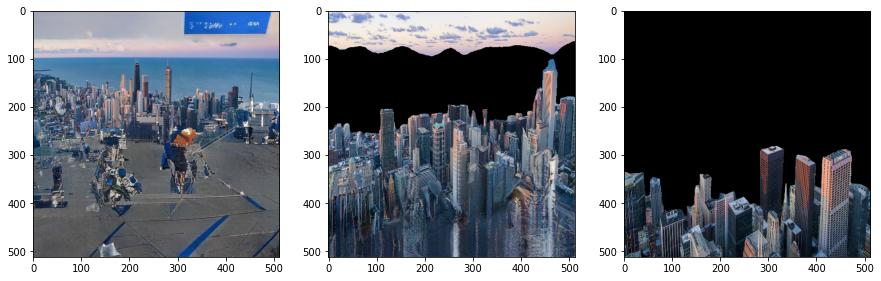

In [16]:
plt.figure(figsize=[15,18])
for i in range(nclass):
   # im = PIL.Image.fromarray(np.uint8(cm.gist_earth(save_mask_img_list[i])*255))
    plt.subplot(1,nclass,i+1)
    plt.imshow(Fixed_img_list[i])

### 2.5 Keying and Saving

In [17]:
print(f"Converting into RGBA images...")

RGBA_img_list=[]
for img in Fixed_img_list:
    alpha_channel = np.ones(img.shape[:2], dtype=img.dtype) * 255
    img_rgba = cv2.merge((img, alpha_channel))
    RGBA_img_list.append(img_rgba)

Transparent_img_list=[]
for img in RGBA_img_list:
    img_with_hole_list=[]
    for height in img:
        for width in height:
            if(width[0]==0)and(width[1]==0)and(width[2]==0):
                img_with_hole_list.append([0,0,0,0])
            else:
                img_with_hole_list.append(width)
    img_with_hole_array = np.array(img_with_hole_list).reshape(img.shape[0],img.shape[1],4)
    Transparent_img_list.append(img_with_hole_array)
    
final_list=[]
transform = T.ToPILImage()
for img in Transparent_img_list:
    tensor_img = torch.tensor(img).permute(2,0,1)
    resize_img = transform(tensor_img/255).resize((original_shape[1],original_shape[0]))
    final_list.append(np.array(resize_img))

print(f"Saving images into folder...")
for i in range(nclass):
    image = PIL.Image.fromarray(final_list[i])
    image.save('save_output/picture_'+ str(i) +'.png')
    
print(f"Finish")

Converting into RGBA images...
Saving images into folder...
Finish


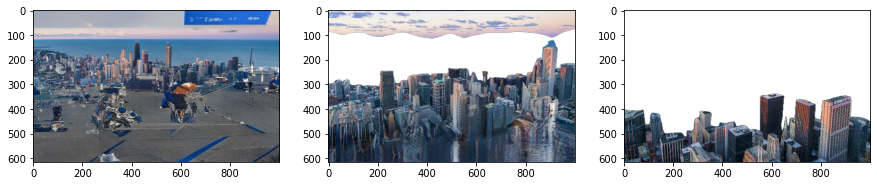

In [18]:
plt.figure(figsize=[15,18])
for i in range(nclass):
    plt.subplot(1,nclass,i+1)
    plt.imshow(final_list[i])

### 2.6 3D Coordinate Setting 

In [19]:
Texture_list = []
for img in final_list:
    Texture_list.append(img.reshape(-1,4))

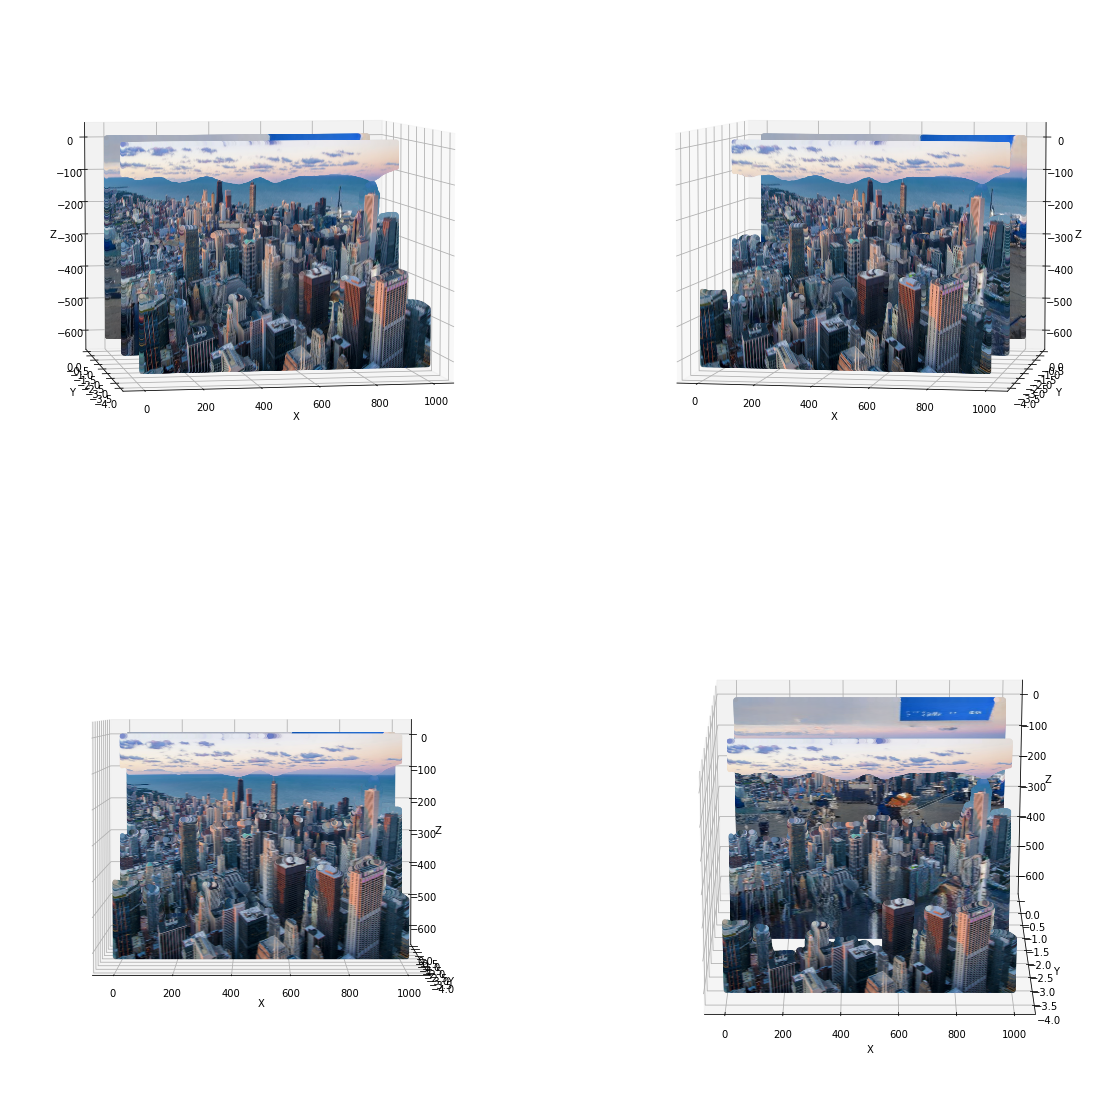

In [20]:
from mpl_toolkits import mplot3d

x = np.linspace(0, final_list[0].shape[1], final_list[0].shape[1])
z = np.linspace(0, final_list[0].shape[0], final_list[0].shape[0])
X, Z = np.meshgrid(x, z)
Y = 10


fig = plt.figure(figsize=[20,20])

ax = fig.add_subplot(221, projection='3d')
ax1 = fig.add_subplot(222, projection='3d')
ax2 = fig.add_subplot(223, projection='3d')
ax3 = fig.add_subplot(224, projection='3d')

ori_pos=0
for img in Texture_list:
    ax.scatter(X, ori_pos, -Z, c=img/255,s=10)
    ori_pos-=2
    
ori_pos=0
for img in Texture_list:
    ax1.scatter(X, ori_pos, -Z, c=img/255,s=10)
    ori_pos-=2

ori_pos=0
for img in Texture_list:
    ax2.scatter(X, ori_pos, -Z, c=img/255,s=10)
    ori_pos-=2
    
ori_pos=0
for img in Texture_list:
    ax3.scatter(X, ori_pos, -Z, c=img/255,s=10)
    ori_pos-=2


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=5,azim=-100)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(elev=5,azim=-80)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.view_init(elev=3,azim=-90)

ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.view_init(elev=20,azim=-90)

plt.show()

## 3. Conclusion
This project presents a system for synthesizing 2.5D models from monocular 2D images. My approach allows users to
customize the number of layers and the distance between layers based on the complexity of the input image. In addition, the system does not require complex hardware devices and can be easily used by general users with 3D software. In the future, I will continue to optimize the performance of the system and hope that the proposed system will help the development of industries such as film and entertainment and medical care.